In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from PIL import Image
import os
import random
import platform

os_name = platform.system()
if os_name == 'Windows':
    PRE_PATH = ''
elif os_name == 'Linux':
    PRE_PATH = '/kkh/'
elif os_name == 'Darwin': # 맥
    PRE_PATH = '/kkh/'

VALIDATION_PREDICTIONS_CSV_PATH = PRE_PATH + 'evaluation/evaluation_validation_predictions.csv'
VALID_IMAGE_PATH = PRE_PATH + 'data/valid_sunho'
META_KR_CSV_PATH = PRE_PATH + 'data/meta_kr.csv'
META_KR_DF = pd.read_csv(META_KR_CSV_PATH)

NUM_CLASSES = 17


In [80]:
def plot_confusion_matrix_and_error_counts(predictions_csv_path, meta_kr_csv_path, num_classes):
    # 데이터 읽기
    df = pd.read_csv(predictions_csv_path)
    y_true = df['target'].values
    y_pred = df['predictions'].values

    # 한국어 클래스명 읽기
    meta_df = pd.read_csv(meta_kr_csv_path)
    class_name_mapping = dict(zip(meta_df['target'], meta_df['class_name_ko']))

    # 혼동 행렬 계산
    cm = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))

    # 혼동 행렬 시각화
    plt.figure(figsize=(8, 4))  # 높이를 4로 설정
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=list(range(num_classes)), yticklabels=list(range(num_classes)))
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()

    # 클래스별 예측 기준 잘못된 예측 개수 계산
    errors_per_class = np.sum(cm, axis=0) - np.diag(cm)

    # 바 차트 시각화
    plt.figure(figsize=(8, 3))  # 높이를 4로 설정
    bars = plt.bar(range(num_classes), errors_per_class, color='black', edgecolor='black')
    plt.xlabel('Predicted Class')
    plt.ylabel('Number of Misclassifications')
    plt.title('Number of Misclassifications per Predicted Class')
    plt.xticks(range(num_classes), range(num_classes))
    
    # 각 바 위에 개수 표시
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', 
                 ha='center', va='bottom')

    plt.show()

    # 실제 클래스와 예측 클래스가 틀린 사례 계산
    error_details = []

    for true_class in range(num_classes):
        for predicted_class in range(num_classes):
            if true_class != predicted_class:
                error_count = cm[true_class, predicted_class]
                if error_count > 0:
                    error_details.append((error_count, true_class, predicted_class))

    # 오류 목록 정렬
    sorted_error_details = sorted(error_details, reverse=True, key=lambda x: x[0])

    # 결과 출력
    for error_count, true_class, predicted_class in sorted_error_details:
        true_class_name = class_name_mapping.get(true_class, 'Unknown')
        predicted_class_name = class_name_mapping.get(predicted_class, 'Unknown')
        print(f"{error_count:>3d}회 틀림 --> 정답: {true_class:>2d} --> 예측: {predicted_class:>2d}  ||  {true_class_name} --> {predicted_class_name}")


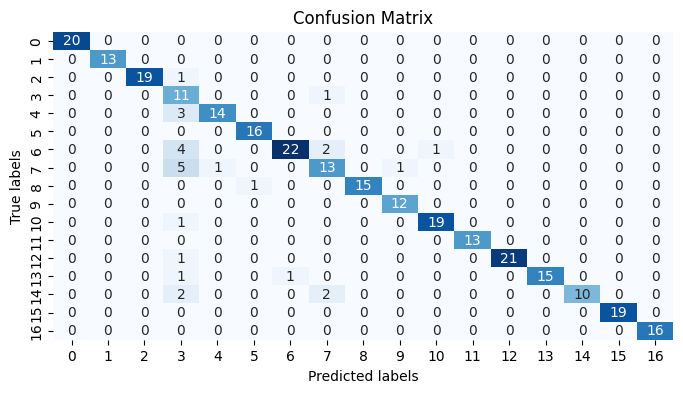

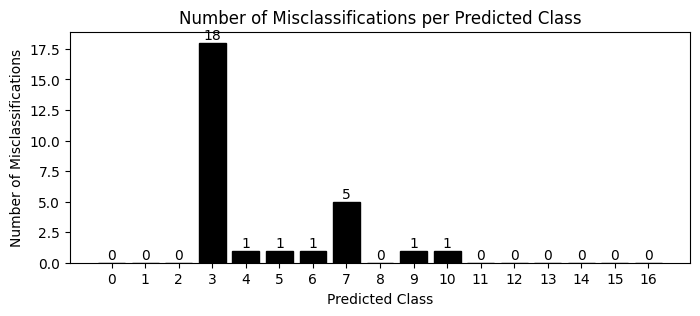

  5회 틀림 --> 정답:  7 --> 예측:  3  ||  통원진료 확인서 --> 입퇴원 확인서
  4회 틀림 --> 정답:  6 --> 예측:  3  ||  진료비영수증 --> 입퇴원 확인서
  3회 틀림 --> 정답:  4 --> 예측:  3  ||  진단서 --> 입퇴원 확인서
  2회 틀림 --> 정답:  6 --> 예측:  7  ||  진료비영수증 --> 통원진료 확인서
  2회 틀림 --> 정답: 14 --> 예측:  3  ||  소견서 --> 입퇴원 확인서
  2회 틀림 --> 정답: 14 --> 예측:  7  ||  소견서 --> 통원진료 확인서
  1회 틀림 --> 정답:  2 --> 예측:  3  ||  자동차 계기판 --> 입퇴원 확인서
  1회 틀림 --> 정답:  3 --> 예측:  7  ||  입퇴원 확인서 --> 통원진료 확인서
  1회 틀림 --> 정답:  6 --> 예측: 10  ||  진료비영수증 --> 진료비 납입 확인서
  1회 틀림 --> 정답:  7 --> 예측:  4  ||  통원진료 확인서 --> 진단서
  1회 틀림 --> 정답:  7 --> 예측:  9  ||  통원진료 확인서 --> 여권
  1회 틀림 --> 정답:  8 --> 예측:  5  ||  주민등록증 --> 운전면허증
  1회 틀림 --> 정답: 10 --> 예측:  3  ||  진료비 납입 확인서 --> 입퇴원 확인서
  1회 틀림 --> 정답: 12 --> 예측:  3  ||  처방전 --> 입퇴원 확인서
  1회 틀림 --> 정답: 13 --> 예측:  3  ||  이력서 --> 입퇴원 확인서
  1회 틀림 --> 정답: 13 --> 예측:  6  ||  이력서 --> 진료비영수증


In [81]:
plot_confusion_matrix_and_error_counts(VALIDATION_PREDICTIONS_CSV_PATH, META_KR_CSV_PATH, NUM_CLASSES)

In [70]:
CLASS_TO_CHECK = 3
NUM_SAMPLE = 12

def display_misclassified_images(predictions_csv_path, image_path, class_to_check, num_sample):
    df = pd.read_csv(predictions_csv_path)
    misclassified_images = []

    # CSV 파일에서 ID, target, predictions 열이 있는지 확인
    if not all(col in df.columns for col in ['ID', 'target', 'predictions']):
        raise ValueError("CSV file must contain 'ID', 'target', and 'predictions' columns.")
    
    for idx, row in df.iterrows():
        true_class = int(row['target'])
        pred_class = int(row['predictions'])
        image_name = row['ID']

        # class_to_check와 일치하고 예측이 틀린 경우
        if pred_class == class_to_check and true_class != pred_class:
            misclassified_images.append((image_name, true_class, pred_class))
            if len(misclassified_images) >= num_sample:
                break

    print(f"Found {len(misclassified_images)} misclassified images for class {class_to_check}.")
    if len(misclassified_images) == 0:
        print("No misclassified images found.")
        return
    
    # Determine number of rows and columns
    num_images = len(misclassified_images)
    num_cols = 3
    num_rows = (num_images + num_cols - 1) // num_cols  # Calculate the number of rows needed
    
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
    axes = axes.flatten()  # Flatten the 2D array of axes to 1D
    
    for ax, (img_name, true_class, pred_class) in zip(axes, misclassified_images):
        img_path = os.path.join(image_path, img_name)
        
        # 이미지 경로 확인
        if not os.path.exists(img_path):
            print(f"Image file not found: {img_path}")
            ax.set_visible(False)
            continue
        
        img = Image.open(img_path)
        
        ax.imshow(img)
        ax.set_title(f"True: {true_class}, Pred: {pred_class}")
        ax.axis('off')
        
        # Add image file name below the image
        ax.set_xlabel(f"File: {img_name}", fontsize=10, color='black')

    # Hide any unused axes
    for ax in axes[len(misclassified_images):]:
        ax.set_visible(False)
    
    plt.tight_layout()
    plt.show()

Found 12 misclassified images for class 3.


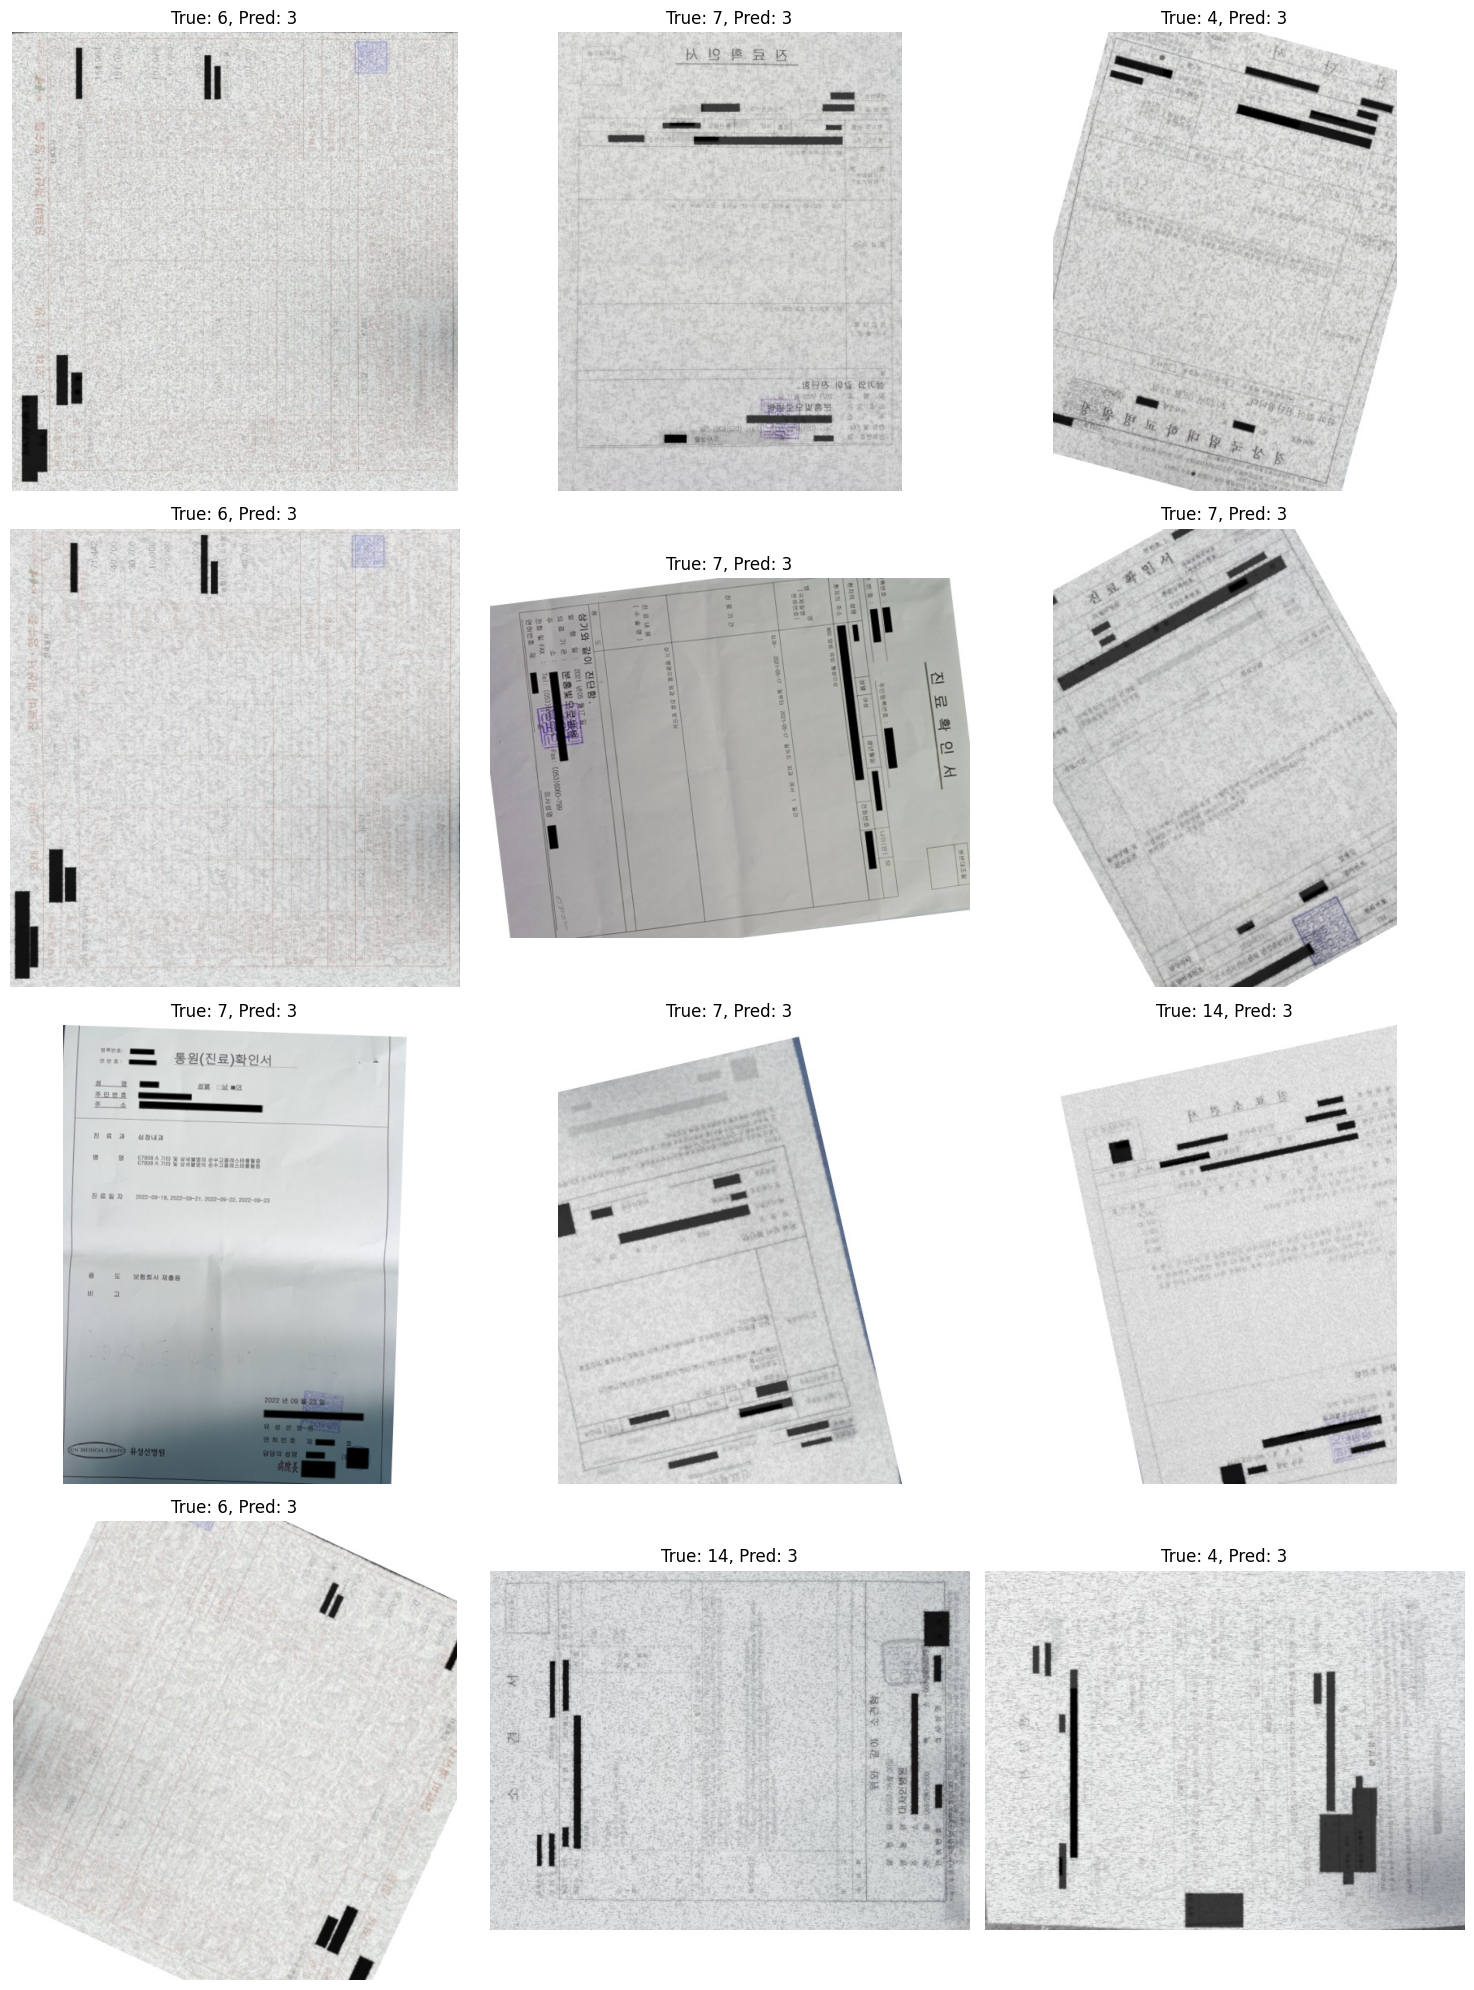

In [71]:
display_misclassified_images(VALIDATION_PREDICTIONS_CSV_PATH, VALID_IMAGE_PATH, CLASS_TO_CHECK, NUM_SAMPLE)